<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/notebooks/cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster Analysis

## Setup

In [1]:
!pip install BIO
!sudo apt install clustalw
# !pip install toytree toyplot
!git clone -b RAPID https://github.com/alibekk93/IDP_analysis
!cd /content/IDP_analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.4/279.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  clustalx seaview
The following NEW packages will be installed:
  clustalw
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 275 kB of archives.
After this operation, 818 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 clustalw amd64 2.1+lgpl-7 [275 kB]
Fetched 275 kB in 1s (480 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling t

In [2]:
from IDP_analysis.packages_import import *
from IDP_analysis.idp_in_bacteria_functions import *

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
sns.set_theme(context='paper', style='white',  palette='colorblind')

Loading Tempura dataset

In [4]:
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/200617_TEMPURA.csv', index_col=0)
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [5]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Classifying bacteria into groups:
1. Psychrophile: OGT <= 20
2. Mesophile: 20 < OGT <= 40
2. Thermophile: 40 < OGT

While this may be quite liberal, some "psychrohiles" with OGT = 20 have *antarctica* in their species name, so it should be fair enough

Psychrophiles would be dropped from this version

In [6]:
tempura = tempura[tempura['Topt_ave'] > 20]
tempura['group'] = ['thermophilic' if t >= 40 else 'mesophilic' for t in tempura['Topt_ave']]

Loading all_proteins

In [7]:
# all_proteins = pd.read_csv('/content/all_proteins.csv', index_col=0)
# all_proteins = pd.read_csv('/content/all_proteins_filtered.csv', index_col=0)
# all_proteins = pd.read_csv('/content/all_proteins_rapid.csv', index_col=0)
# all_proteins = pd.read_csv('/content/all_proteins_types.csv', index_col=0)

Merging all_proteins with temura

In [8]:
# all_proteins = all_proteins.merge(tempura, left_on='Species', right_on='genus_and_species')

setting colors

In [9]:
green = '#1BE434'
red = '#E4341B'

loading cluster data

In [10]:
clusters_df = pd.read_pickle('/content/IDP_analysis/datafiles/clusters/interesting_clusters_fIDPnn.pkl')

In [11]:
clusters_df['fIDPnn_FOD'] = clusters_df['fIDPnn_disorder'].apply(np.mean)
clusters_df['fIDPnn_binary'] = clusters_df['fIDPnn_disorder'].apply(lambda disorder: [r >= 0.5 for r in disorder])
clusters_df['fIDPnn_longest_IDR'] = clusters_df['fIDPnn_binary'].apply(find_longest_binary_IDR)
clusters_df['fIDPnn_with_IDR'] = clusters_df['fIDPnn_longest_IDR'] > 30

## Annotations

In [12]:
# failures = []

# def get_uniprot_info(uniprot_id):
#   url = f'https://rest.uniprot.org/uniprotkb/{uniprot_id}.json'
#   headers = {'Accept': 'application/json'}
#   try:
#     response = requests.get(url, headers)
#     return response.text
#   except:
#     failures.append(uniprot_id)
#     return None

In [13]:
# failures

In [14]:
# tqdm.pandas(desc='Getting data from UniProt')
# uniprot_jsons = clusters_df['ID'].progress_apply(get_uniprot_info)

In [15]:
# with open('uniprot_jsons.pkl', 'wb') as f:
#   pickle.dump(uniprot_jsons, f)

In [16]:
# with open('uniprot_jsons.pkl', 'rb') as f:
#   uniprot_jsons = pickle.load(f)

In [17]:
# uniprot_jsons_loaded = uniprot_jsons.apply(json.loads)

In [18]:
# keywords_dict = {}

# for idx in uniprot_jsons_loaded.index:
#   protein_json = uniprot_jsons_loaded.loc[idx]
#   try:
#     keywords_dict[idx] = pd.DataFrame({kw['category']:[kw['name']] for kw in protein_json['keywords']})
#   except:
#     keywords_dict[idx] = pd.DataFrame({'no_keywords':[True]})

In [19]:
# keywords_df = pd.concat(keywords_dict, ignore_index=True)
# keywords_df.index = keywords_dict.keys()

In [20]:
# keywords_df.to_csv('/content/IDP_analysis/datafiles/clusters/keywords_df.csv')

In [21]:
keywords_df = pd.read_csv('/content/IDP_analysis/datafiles/clusters/keywords_df.csv', index_col=0)

In [22]:
keywords_df.columns

Index(['Cellular component', 'Molecular function', 'Ligand',
       'Biological process', 'PTM', 'no_keywords', 'Technical term', 'Domain'],
      dtype='object')

In [23]:
clusters_df[keywords_df.columns] = keywords_df

In [24]:
clusters_df[keywords_df.columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11476 entries, 145 to 1132054
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Cellular component  3485 non-null   object
 1   Molecular function  9556 non-null   object
 2   Ligand              4083 non-null   object
 3   Biological process  4290 non-null   object
 4   PTM                 813 non-null    object
 5   no_keywords         375 non-null    object
 6   Technical term      6606 non-null   object
 7   Domain              1472 non-null   object
dtypes: object(8)
memory usage: 806.9+ KB


In [25]:
clusters_df.groupby('Molecular function').size()

Molecular function
Activator                   33
Chaperone                  534
DNA-binding                512
Elongation factor          400
Excision nuclease          199
Hydrolase                  223
Initiation factor           59
Isomerase                   94
Ligase                     348
Lyase                      241
Multifunctional enzyme      14
Nuclease                    18
Oxidoreductase             258
Peroxidase                  62
Protease                   291
RNA-binding                405
Receptor                    11
Repressor                   55
Ribosomal protein         1969
Rotamase                    40
Serine protease             50
Sigma factor               172
Topoisomerase              157
Transferase                740
Translocase                134
rRNA-binding              1796
tRNA-binding               741
dtype: int64

## Cluster alignment

In [26]:
# large_clusters = {cluster:clusters_df[clusters_df['cluster']==cluster] for cluster in clusters_df['cluster'].unique()}

In [27]:
# aligned_clusters = {}

# for cluster, cluster_df in tqdm(large_clusters.items()):
#   try:
#     cluster_df['disorder_aligned'] = align_disorder(disorder_values=cluster_df['fIDPnn_disorder'],
#                                                     seqs=cluster_df['Sequence'], ids=cluster_df['ID'])[1]

#     cluster_df['group'] = [tempura[tempura['genus_and_species']==s]['group'].iloc[0] for s in cluster_df['Species']]

#     cluster_df['color'] = cluster_df['group'].map({'psychrophilic':'blue',
#                                                     'mesophilic':'green',
#                                                     'thermophilic':'red'})
#     cluster_df['species_tag'] = cluster_df['Species']

#     aligned_clusters[cluster] = cluster_df
#   except:
#     aligned_clusters[cluster] = None

In [28]:
# with open('/content/IDP_analysis/datafiles/clusters/aligned_clusters.pkl', 'wb') as f:
#   pickle.dump(aligned_clusters, f)

In [29]:
with open('/content/IDP_analysis/datafiles/clusters/aligned_clusters.pkl', 'rb') as f:
  aligned_clusters = pickle.load(f)

## Cluster analysis

In [30]:
aligned_clusters_df = pd.concat(aligned_clusters)
aligned_clusters_df.index = aligned_clusters_df.index.get_level_values(1)
clusters_df[['disorder_aligned', 'color', 'species_tag']] = aligned_clusters_df[['disorder_aligned', 'color', 'species_tag']]

In [34]:
clusters_df.groupby(['Molecular function', 'group'], as_index=False)['fIDPnn_FOD'].agg(['size', 'mean', 'sem'])

size      mean       sem
Molecular function     group                                 
Activator              mesophilic      33  0.338875  0.009841
Chaperone              mesophilic     516  0.113666  0.002554
                       thermophilic    18  0.090390  0.009617
DNA-binding            mesophilic     477  0.263960  0.007578
                       thermophilic    35  0.276056  0.031952
Elongation factor      mesophilic     367  0.069675  0.004627
                       thermophilic    33  0.124681  0.033648
Excision nuclease      mesophilic     192  0.054009  0.000982
                       thermophilic     7  0.052544  0.005048
Hydrolase              mesophilic     209  0.107621  0.009067
                       thermophilic    14  0.063698  0.005463
Initiation factor      mesophilic      56  0.208572  0.004126
                       thermophilic     3  0.216778  0.025575
Isomerase              mesophilic      91  0.075864  0.001140
                       thermophilic     3  0.090143  0.023636
Ligase                 mesophilic     336  0.057744  0.002494
                       thermophilic    12  0.060108  0.008101
Lyase                  mesophilic     230  0.076174  0.001225
                       thermophilic    11  0.077156  0.004568
Multifunctional enzyme mesophilic      13  0.052481  0.001177
                       thermophilic     1  0.055192       NaN
Nuclease               mesophilic      18  0.109975  0.003373
Oxidoreductase         mesophilic     245  0.073367  0.002163
                       thermophilic    13  0.101846  0.017795
Peroxidase             mesophilic      59  0.096949  0.004062
                       thermophilic     3  0.081819  0.007482
Protease               mesophilic     284  0.079587  0.001024
                       thermophilic     7  0.082274  0.008098
RNA-binding            mesophilic     388  0.125919  0.004805
                       thermophilic    17  0.165000  0.033027
Receptor               mesophilic      10  0.112148  0.015608
                       thermophilic     1  0.095223       NaN
Repressor              mesophilic      51  0.263069  0.017174
                       thermophilic     4  0.331160  0.085624
Ribosomal protein      mesophilic    1859  0.437450  0.004474
                       thermophilic   110  0.467447  0.018371
Rotamase               mesophilic      36  0.208764  0.010008
                       thermophilic     4  0.191468  0.030457
Serine protease        mesophilic      49  0.062703  0.001089
                       thermophilic     1  0.061647       NaN
Sigma factor           mesophilic     154  0.149253  0.003492
                       thermophilic    18  0.142425  0.010856
Topoisomerase          mesophilic     151  0.087461  0.000878
                       thermophilic     6  0.074857  0.006801
Transferase            mesophilic     713  0.073203  0.002586
                       thermophilic    27  0.087395  0.012302
Translocase            mesophilic     127  0.075601  0.003513
                       thermophilic     7  0.048839  0.003898
rRNA-binding           mesophilic    1700  0.283927  0.002264
                       thermophilic    96  0.294175  0.010292
tRNA-binding           mesophilic     686  0.297098  0.005122
                       thermophilic    55  0.337626  0.014691

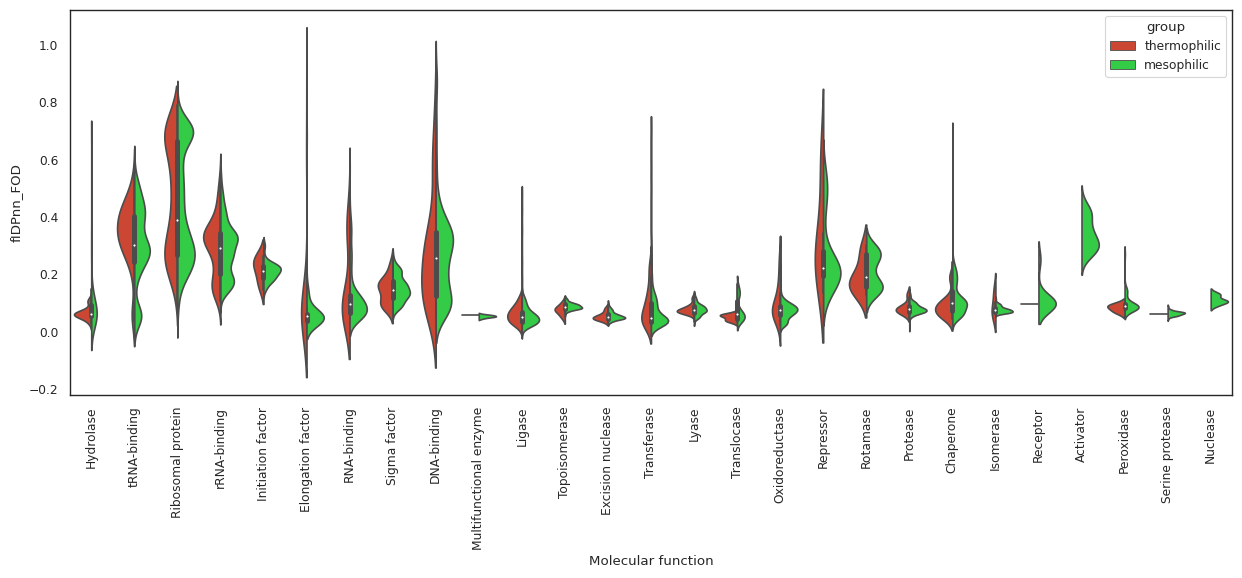

In [32]:
fig, ax = plt.subplots(figsize=(15,5))

sns.violinplot(data=clusters_df, x='Molecular function', y='fIDPnn_FOD',
               split=True, hue='group', palette=[red, green])
plt.xticks(rotation=90)

plt.show()

In [35]:
clusters_df[clusters_df['Molecular function']=='Activator']

,ID,Sequence,Length,Species,RAPID_disorder,f_plus,f_minus,ncpr,fcr,idp_type,...,Molecular function,Ligand,Biological process,PTM,no_keywords,Technical term,Domain,disorder_aligned,color,species_tag
55350,A0A1D7QSE6,MTQGTVKWFNAEKGFGFIEVEGQDDVFVHFSAIQGEGFKSLDEGQT...,65,Bacillus beveridgei,0.3231,0.092308,0.153846,0.061538,0.246154,1,...,Activator,NaN,Transcription regulation,NaN,NaN,Reference proteome,NaN,"[0.449, 0.381, 0.399, 0.40800000000000003, 0.4...",green,Bacillus beveridgei
55371,A0A1D7QSI2,MQGKVKWFNAEKGFGFIEREDGEDVFVHYSAIDQEGFKSLDEGQHV...,65,Bacillus beveridgei,0.2615,0.138462,0.200000,0.061538,0.338462,2,...,Activator,NaN,Transcription regulation,NaN,NaN,Reference proteome,NaN,"[0.302, 0.321, 0.33766666666666667, 0.35433333...",green,Bacillus beveridgei
55749,A0A1D7QU35,MTQGTVKWFNAEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEEGQA...,65,Bacillus beveridgei,0.5077,0.092308,0.153846,0.061538,0.246154,1,...,Activator,NaN,Transcription regulation,NaN,NaN,Reference proteome,NaN,"[0.441, 0.374, 0.39, 0.40449999999999997, 0.41...",green,Bacillus beveridgei
57145,A0A1D7QZL4,MTQGTVKWFNAEKGFGFIEIEGQDDVFVHFSAIEGEGFKTLDEGQT...,65,Bacillus beveridgei,0.3385,0.092308,0.169231,0.076923,0.261538,2,...,Activator,NaN,Transcription regulation,NaN,NaN,Reference proteome,NaN,"[0.425, 0.363, 0.382, 0.396, 0.41, 0.307, 0.30...",green,Bacillus beveridgei
101188,A0A3E0WMI1,MTGKVKWFNAEKGFGFIEREDGDDVFVHFSAIQADGFKTLEEGQDV...,65,Virgibacillus dokdonensis,0.2462,0.123077,0.200000,0.076923,0.323077,2,...,Activator,NaN,Transcription regulation,NaN,NaN,NaN,NaN,"[nan, 0.311, 0.328, 0.3435, 0.359, 0.262, 0.25...",green,Virgibacillus dokdonensis
130610,A0A1W5ZVR2,MKTGTVKWFNAEKGFGFIEIEGEDDVFVHFSAINEEGFKSLEEGQS...,66,Halobacillus mangrovi,0.5758,0.106061,0.196970,0.090909,0.303030,2,...,Activator,NaN,Transcription regulation,NaN,NaN,NaN,NaN,"[0.365, 0.295, 0.32, 0.318, 0.316, 0.248, 0.24...",green,Halobacillus mangrovi
130638,A0A1W5ZVV1,MLQGNVKWFNAEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEENET...,65,Halobacillus mangrovi,0.2462,0.092308,0.169231,0.076923,0.261538,2,...,Activator,NaN,Transcription regulation,NaN,NaN,NaN,NaN,"[0.427, 0.405, 0.408, 0.4, 0.392, 0.294, 0.297...",green,Halobacillus mangrovi
131145,A0A1W5ZXS9,MVEGTVKWFNAEKGFGFIEVEGQDDVFVHFSAIQEEGFKSLEEGQV...,65,Halobacillus mangrovi,0.2923,0.092308,0.200000,0.107692,0.292308,2,...,Activator,NaN,Transcription regulation,NaN,NaN,NaN,NaN,"[0.375, 0.359, 0.381, 0.3755, 0.37, 0.278, 0.2...",green,Halobacillus mangrovi
171361,A0A0U4FPM7,MTGTVKWFNAEKGFGFIEREEGDDVFVHFSAINAEGFKTLEDGQNV...,65,Lentibacillus amyloliquefaciens,0.2308,0.092308,0.184615,0.092308,0.276923,2,...,Activator,NaN,Transcription regulation,NaN,NaN,Reference proteome,NaN,"[nan, 0.295, 0.306, 0.3255, 0.345, 0.271, 0.25...",green,Lentibacillus amyloliquefaciens
208543,A0A3Q9QQM5,MENGKVKWFNSEKGFGFIERQGGEDVFVHFSAIQGEGFKTLEEGQE...,66,Bacillus mesonae,0.6212,0.136364,0.166667,0.030303,0.303030,2,...,Activator,NaN,Transcription regulation,NaN,NaN,Reference proteome,NaN,"[0.505, 0.438, 0.448, 0.461, 0.377, 0.382, 0.3...",green,Bacillus mesonae


Finding clusters that are either unique for a group or have combinations

In [ ]:
m_only_clusters = {}
t_only_clusters = {}
combination_clusters = {}

for cluster in tqdm(clusters_df['cluster'].unique()):
  cluster_df = clusters_df[clusters_df['cluster']==cluster]
  try:
    groups = cluster_df['group'].unique().tolist()
    if groups == ['mesophilic']:
      m_only_clusters[cluster] = cluster_df
    elif groups == ['thermophilic']:
      t_only_clusters[cluster] = cluster_df
    else:
      combination_clusters[cluster] = cluster_df
  except:
    continue

100%|██████████| 616/616 [00:00<00:00, 1358.72it/s]


In [ ]:
print(len(m_only_clusters))
print(len(t_only_clusters))
print(len(combination_clusters))

296
0
320


In [ ]:
combination_clusters = pd.concat(combination_clusters, ignore_index=True)

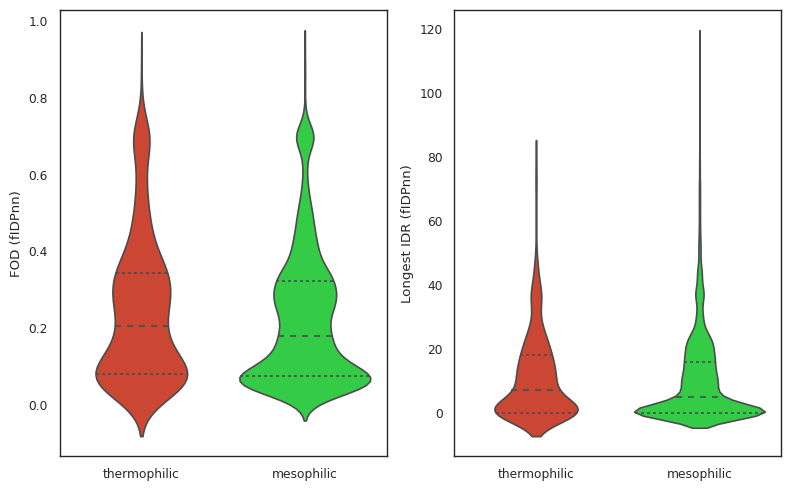

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8,5))

sns.violinplot(data=combination_clusters, x='group', y='fIDPnn_FOD', inner='quart', palette=[red, green], ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('FOD (fIDPnn)')

sns.violinplot(data=combination_clusters, x='group', y='fIDPnn_longest_IDR', inner='quart', palette=[red, green], ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('Longest IDR (fIDPnn)')

plt.tight_layout()

fig.show()

In [ ]:
scipy.stats.ttest_ind(combination_clusters[combination_clusters['group']=='mesophilic']['fIDPnn_FOD'],
                      combination_clusters[combination_clusters['group']=='thermophilic']['fIDPnn_FOD'])

TtestResult(statistic=-3.02102070077409, pvalue=0.0025280036548684585, df=7269.0)

In [ ]:
combination_clusters.groupby('group')['fIDPnn_FOD'].agg(['mean', 'sem'])

,mean,sem
group,,
mesophilic,0.223186,0.002167
thermophilic,0.245459,0.007472


In [ ]:
scipy.stats.ttest_ind(combination_clusters[combination_clusters['group']=='mesophilic']['fIDPnn_longest_IDR'],
                      combination_clusters[combination_clusters['group']=='thermophilic']['fIDPnn_longest_IDR'])

TtestResult(statistic=-1.5870607277313185, pvalue=0.11254238623468454, df=7269.0)

In [ ]:
combination_clusters.groupby('group')['fIDPnn_longest_IDR'].agg(['mean', 'sem'])

,mean,sem
group,,
mesophilic,10.225019,0.166705
thermophilic,11.117925,0.526926


In [ ]:
disordered_combos = combination_clusters.groupby(['cluster', 'group'], as_index=False)
disordered_combos = disordered_combos.agg({'fIDPnn_FOD':'mean', 'fIDPnn_longest_IDR':'max'})
disordered_combos = disordered_combos[disordered_combos['fIDPnn_longest_IDR']>30]
disordered_combos_std = disordered_combos.groupby('cluster', as_index=False).std()
disordered_combos_std.sort_values('fIDPnn_FOD', ascending=False).head()

,cluster,fIDPnn_FOD,fIDPnn_longest_IDR
55,893670.0,0.100280,2.121320
58,908872.0,0.098435,2.121320
46,842370.0,0.058275,12.727922
43,820723.0,0.056740,0.707107
41,819321.0,0.036289,0.000000


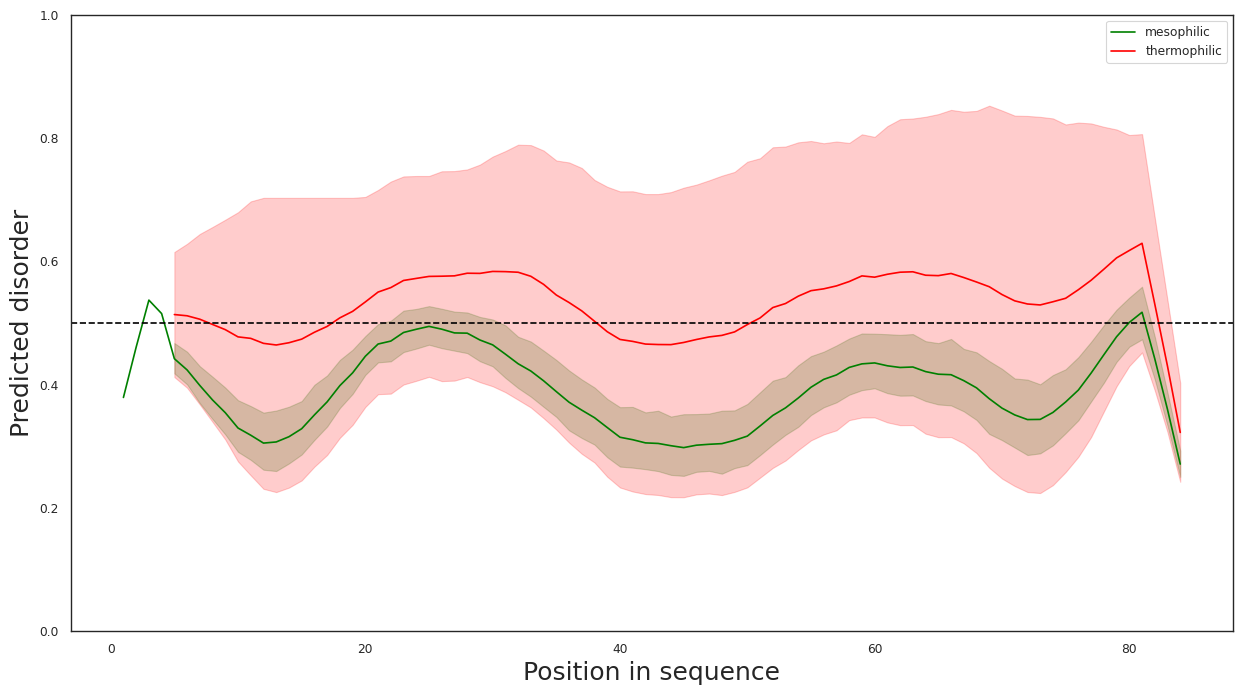

In [ ]:
test_cluster = 893670
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

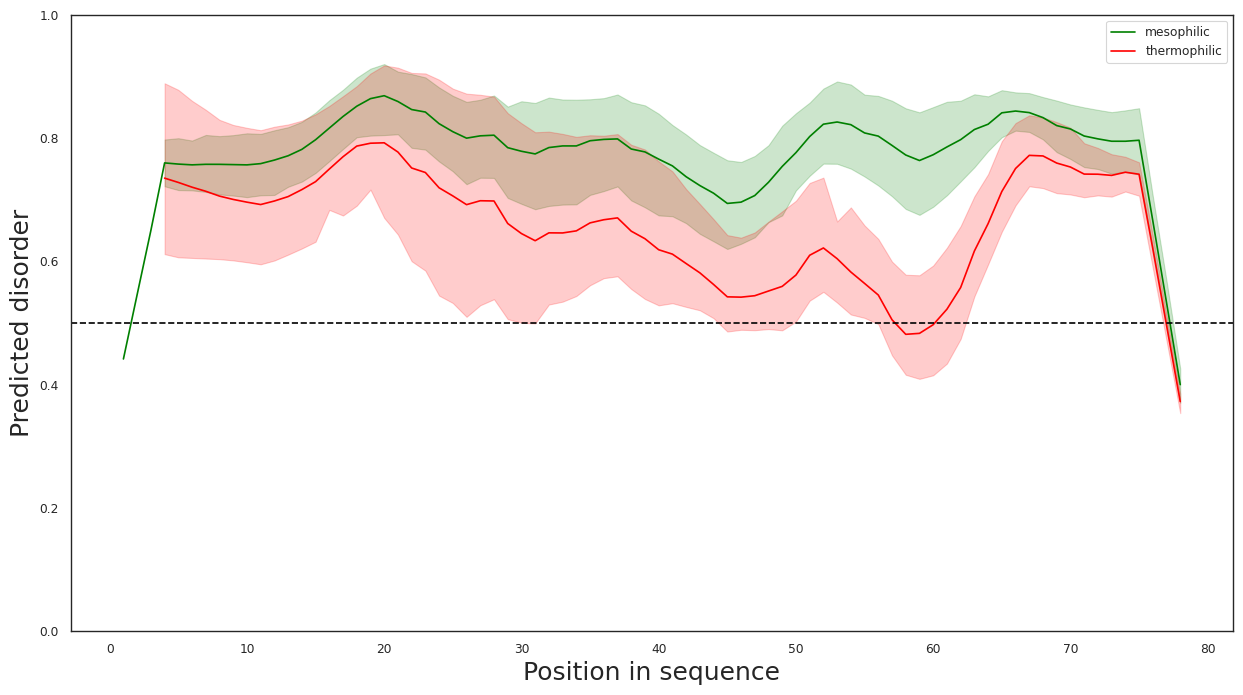

In [ ]:
test_cluster = 908872
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

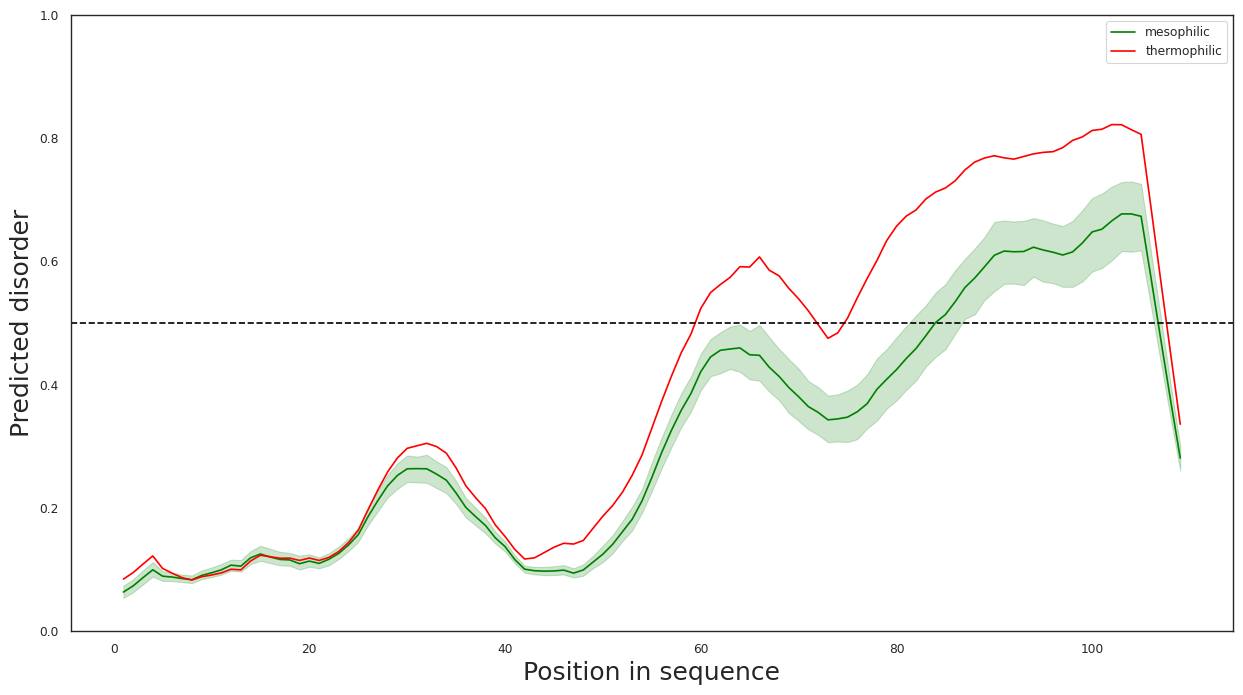

In [ ]:
test_cluster = 842370
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

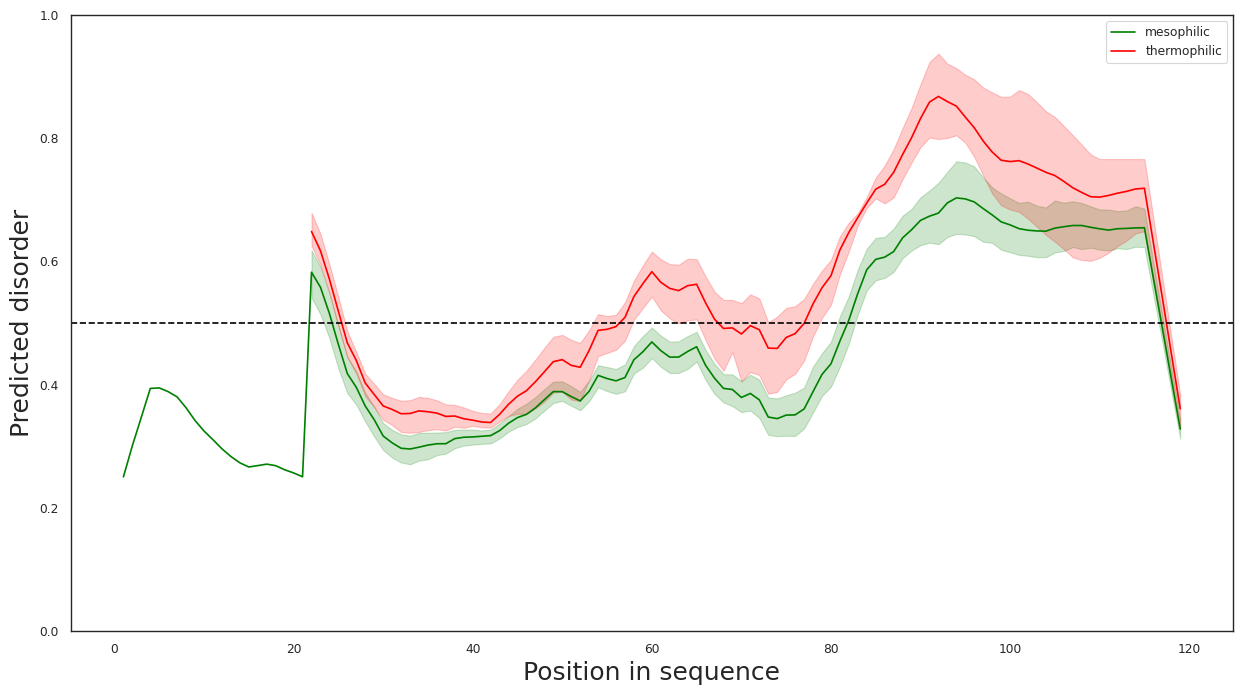

In [ ]:
test_cluster = 820723
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

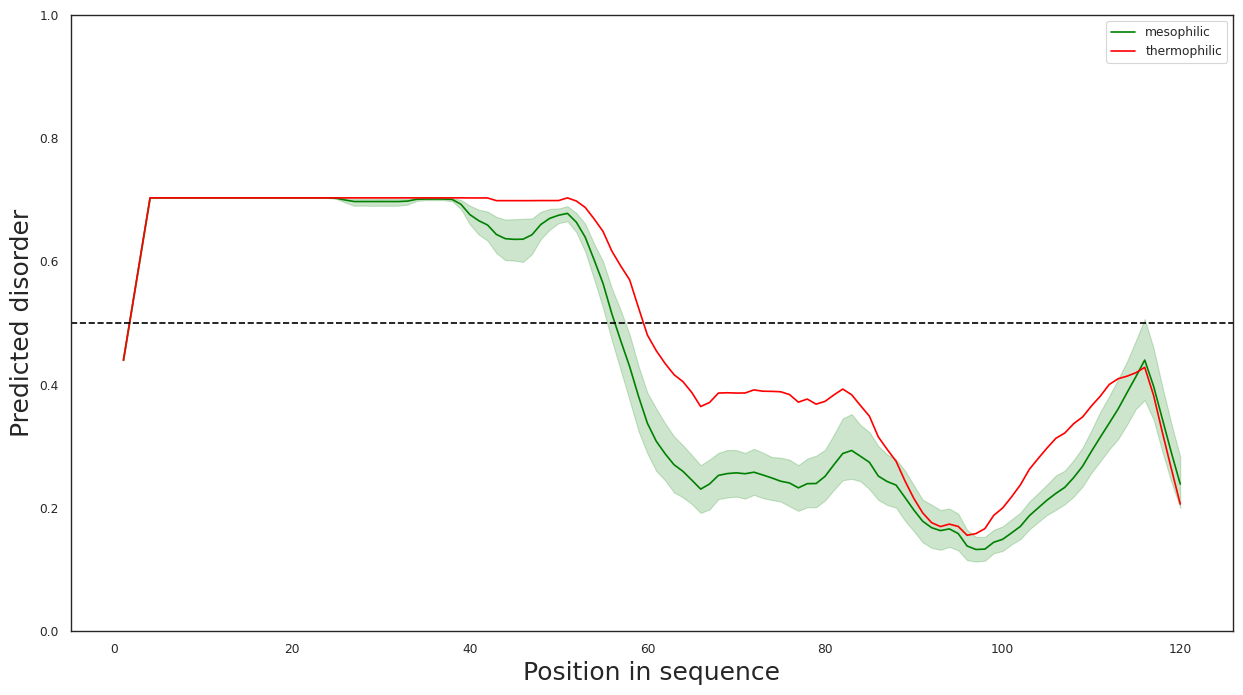

In [ ]:
test_cluster = 819321
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

In [ ]:
combination_clusters.groupby(['Molecular function'])['fIDPnn_FOD'].agg(['size', 'mean', 'sem'])

,size,mean,sem
Molecular function,,,
Activator,9,0.354621,0.023561
Chaperone,314,0.091939,0.001706
DNA-binding,322,0.253350,0.010682
Elongation factor,300,0.078972,0.006322
Excision nuclease,98,0.049490,0.001346
Hydrolase,177,0.075334,0.006032
Initiation factor,38,0.213931,0.005529
Isomerase,24,0.072655,0.002959
Ligase,223,0.059630,0.002658


In [ ]:
test = combination_clusters[combination_clusters['Molecular function']=='Sigma factor']
test.groupby('group')['fIDPnn_longest_IDR'].agg(['mean', 'sem', 'count'])

,mean,sem,count
group,,,
mesophilic,4.648352,1.044478,91
thermophilic,6.722222,2.881999,18


In [ ]:
test['cluster'].unique()

array([535624., 256609., 521751., 540205.])

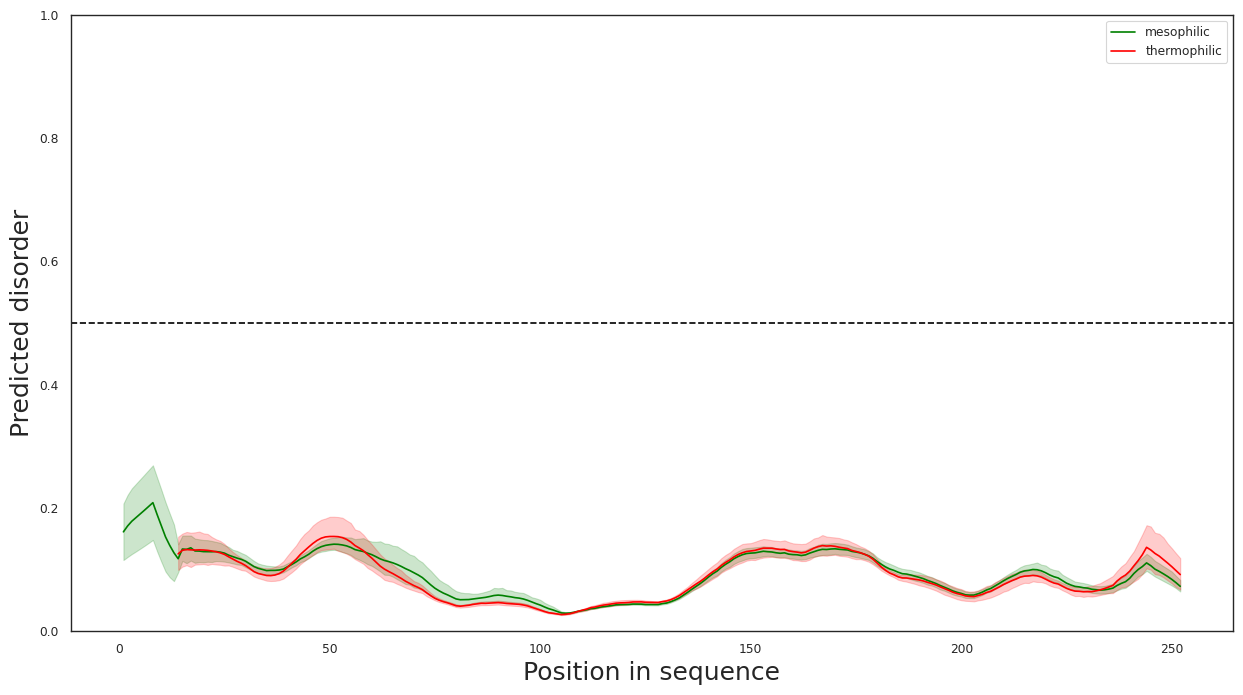

In [ ]:
test_cluster = 535624
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

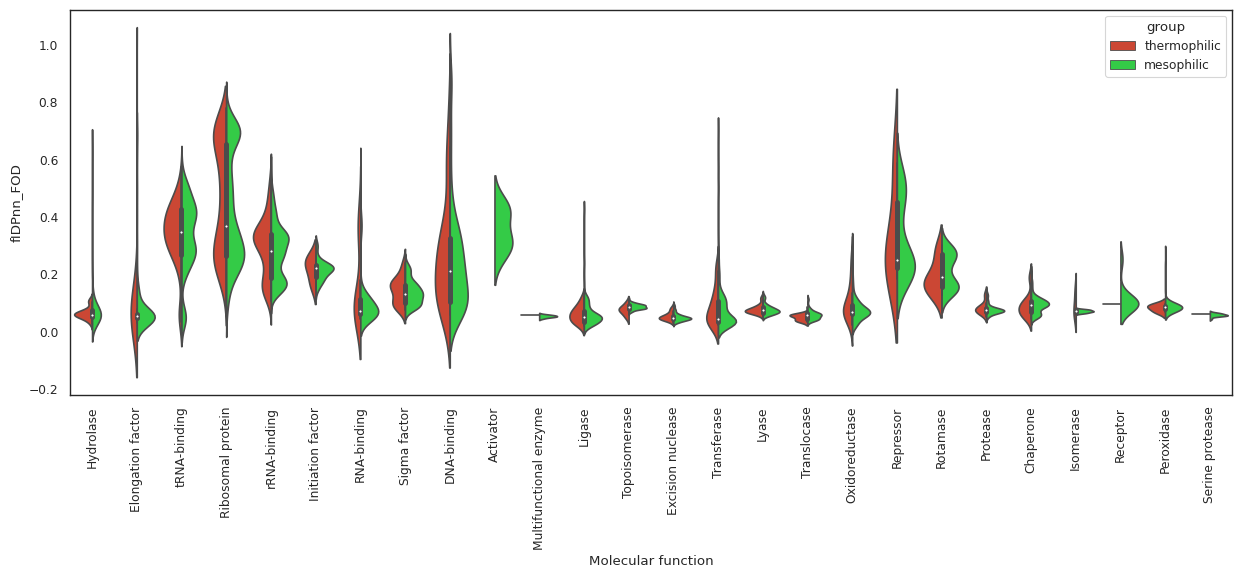

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

sns.violinplot(data=combination_clusters, x='Molecular function', y='fIDPnn_FOD',
               split=True, hue='group', palette=[red, green])
plt.xticks(rotation=90)

plt.show()

## Cluster analysis - exclusively mesophilic

In [ ]:
m_only_clusters = pd.concat(m_only_clusters, ignore_index=True)

In [ ]:
m_only_clusters.groupby('Molecular function')['fIDPnn_FOD'].agg(['size', 'mean', 'sem'])

,size,mean,sem
Molecular function,,,
Activator,24,0.332971,0.010359
Chaperone,220,0.142772,0.004887
DNA-binding,190,0.284168,0.008093
Elongation factor,100,0.059934,0.007463
Excision nuclease,101,0.058292,0.001234
Hydrolase,46,0.218486,0.028847
Initiation factor,21,0.200047,0.005112
Isomerase,70,0.077576,0.001389
Ligase,125,0.054606,0.004799


In [ ]:
def model_cluster(cluster_number, df=clusters_df, plot=False):
  df = df[df['cluster']==cluster_number]
  df = pd.merge(left=df, right=tempura, left_on='Species', right_on='genus_and_species')
  cluster_model = sm.OLS(df['fIDPnn_FOD'], sm.add_constant(df['Topt_ave'])).fit()

  if plot:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.scatterplot(data=df, x='Topt_ave', y='fIDPnn_FOD', color='black', alpha=0.5, ax=ax)
    sns.lineplot(x=df['Topt_ave'], y=cluster_model.predict(sm.add_constant(df['Topt_ave'])), ax=ax, color='red')
    plt.show()
  return (cluster_model.rsquared, cluster_model.params[1])

In [ ]:
model_results = {cluster:model_cluster(cluster) for cluster in combination_clusters['cluster'].unique()}
model_results = pd.DataFrame(model_results.values(), columns=['rsq', 'coef'], index=model_results.keys())
model_results.sort_values('rsq')

KeyError: ignored

In [ ]:
model_cluster(73523, plot=True)

In [ ]:
model_cluster(30963, plot=True)

In [ ]:
model_cluster(595740, plot=True)

In [ ]:
model_results['rsq'].mean()

In [ ]:
model_results['coef'].mean()

In [ ]:
clusters_df = pd.merge(left=clusters_df, right=tempura, left_on='Species', right_on='genus_and_species')

In [ ]:
clusters_df['fIDPnn_FOD']

In [ ]:
X = clusters_df['Topt_ave']
y = clusters_df['fIDPnn_FOD']

FOD_OGT_line_model_clusters = sm.OLS(y, sm.add_constant(X)).fit()
print(FOD_OGT_line_model_clusters.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=clusters_df, x='Topt_ave', y='fIDPnn_FOD', color='black', ax=ax, alpha=0.5)
plt.ylabel('Fraction of disorder (fIDPnn)')
plt.xlabel('Optimal growth temperature, °C')

sns.lineplot(x=clusters_df['Topt_ave'], y=FOD_OGT_line_model_clusters.predict(sm.add_constant(clusters_df['Topt_ave'])), ax=ax, color='red')
# sns.lineplot(x=clusters_df['Topt_ave'], y=FOD_OGT_line_model_clusters.predict(sm.add_constant(clusters_df['Topt_ave']**2)), ax=ax, color='green')

plt.tight_layout()

fig.show()
fig.savefig('FOD_OGT_clusters.svg')

In [ ]:
clusters_df

In [ ]:
Entrez.email = "akrug104@uottawa.ca"

def get_protein_info(uniprot_id):
  try:
    handle = Entrez.efetch(db="protein", id=uniprot_id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()
    return record[0]['GBSeq_keywords']
  except:
    return None

In [ ]:
get_protein_info('A4G9U0')

In [ ]:
clusters_df['keywords'] = clusters_df['ID'].apply(get_protein_info)

In [ ]:
clusters_df.loc[205]